In [1]:
from pathlib import Path as pt
import umap
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from typing import List
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from typing import Dict, Tuple

from rdkit import Chem
from sklearn.cluster import DBSCAN

warnings.filterwarnings('ignore')
tqdm.pandas()

In [2]:
from dbcv import dbcv
from sklearn.manifold import trustworthiness

In [3]:
from load_data import embedded_vectors_dir, names, titles, plots_dir, property_units, property_names
names, plots_dir

(['tmpC_topelements',
  'tbp_topelements',
  'vp_kPa_25C_topelements',
  'Pc_MPa',
  'Tc_K'],
 PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/plots'))

In [4]:
class ChemicalClusterAnalyzer:
    """Analyzes chemical structure clusters and their functional groups."""

    def __init__(self):
        # Define common functional groups and their SMARTS patterns
        self.functional_groups = {
            "Alcohol": "[OH]",
            "Carboxylic Acid": "[CX3](=O)[OX2H1]",
            "Ester": "[#6][CX3](=O)[OX2H0][#6]",
            "Ether": "[OD2]([#6])[#6]",
            "Aldehyde": "[CX3H1](=O)[#6]",
            "Ketone": "[#6][CX3](=O)[#6]",
            "Amine": "[NX3;H2,H1;!$(NC=O)]",
            "Amide": "[NX3][CX3](=[OX1])[#6]",
            "Aromatic": "a1aaaaa1",
            "Alkene": "[CX3]=[CX3]",
            "Alkyne": "[CX2]#[CX2]",
            "Nitrile": "[NX1]#[CX2]",
            "Nitro": "[NX3](=O)=O",
            "Sulfonic Acid": "[SX4](=[OX1])(=[OX1])[OX2H]",
            "Phosphate": "[PX4](=[OX1])([OX2H])([OX2H])[OX2H]",
            "Halogen": "[F,Cl,Br,I]",
        }

    def identify_functional_groups(self, smiles: str) -> Dict[str, int]:
        """
        Identifies functional groups in a molecule.

        Args:
            smiles: SMILES string of the molecule

        Returns:
            Dictionary of functional group counts
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return {}

            groups = {}
            for name, smarts in self.functional_groups.items():
                pattern = Chem.MolFromSmarts(smarts)
                if pattern is not None:
                    matches = mol.GetSubstructMatches(pattern)
                    if matches:
                        groups[name] = len(matches)
            return groups
        except Exception:
            return {}

    def analyze_cluster_chemistry(
        self,
        reduced_embeddings: np.ndarray,
        smiles_list: List[str],
        eps: float = 0.5,
        min_samples: int = 5,
    ) -> Tuple[np.ndarray, Dict]:
        """
        Performs clustering and analyzes chemical features of each cluster.

        Args:
            reduced_embeddings: UMAP-reduced embeddings
            smiles_list: List of SMILES strings
            eps: DBSCAN epsilon parameter
            min_samples: DBSCAN minimum samples parameter

        Returns:
            Cluster labels and cluster analysis results
        """
        # Perform DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(reduced_embeddings)
        labels = clustering.labels_

        # Analyze each cluster
        cluster_analysis = {}
        for cluster_id in tqdm(set(labels)):
            if cluster_id == -1:  # Skip noise points
                continue

            # Get SMILES strings for this cluster
            cluster_mask = labels == cluster_id
            cluster_smiles = np.array(smiles_list)[cluster_mask]

            # Analyze functional groups
            all_groups = []
            for smiles in cluster_smiles:
                groups = self.identify_functional_groups(smiles)
                all_groups.extend(groups.keys())

            # Calculate group frequencies
            group_freq = Counter(all_groups)
            total_mols = len(cluster_smiles)
            group_freq = {k: v / total_mols for k, v in group_freq.items()}

            # Store analysis results
            cluster_analysis[cluster_id] = {
                "size": sum(cluster_mask),
                "functional_groups": group_freq,
                "center": reduced_embeddings[cluster_mask].mean(axis=0),
            }

        return labels, cluster_analysis



In [5]:
def get_umap_df(
    ind: int,
    n_neighbors = 15,
    min_dist = 0.1,
    random_state = 42,
    dbscan_eps = 0.7,
    dbscan_min_samples = 15,
    perplexity = 3,
    mode: str = 'umap'
):
    
    n_components = 2
    
    df = pd.read_parquet(embedded_vectors_dir[ind] / 'processed_mol2vec_embeddings' / 'processed_df.parquet')
    label_issues_df = pd.read_parquet(
        embedded_vectors_dir[ind] / 'processed_mol2vec_embeddings' / 'label_issues_xgboost.parquet'
    )
    cleaned_df = df[~label_issues_df["is_label_issue"]]
    print(f'Original data: {df.shape}, Cleaned data: {cleaned_df.shape}')

    smiles_list = cleaned_df['SMILES'].to_list()
    print(f'SMILES list: {len(smiles_list)}')

    X = cleaned_df.values[:, 2:]
    y = cleaned_df["y"].values
    print(f'X: {X.shape}, y: {y.shape}')

    # Scale embeddings
    print("Scaling embeddings...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform UMAP
    if mode == 'umap':
        print("Performing UMAP...")
        reducer = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=n_components,
            n_jobs=-1,
            random_state=random_state
        )

        reduced_embeddings = reducer.fit_transform(X_scaled)
        print(f'UMAP done: {reduced_embeddings.shape}')
    elif mode == 'tsne':    
        reducer = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=perplexity)
        reduced_embeddings = reducer.fit_transform(X_scaled)
        print(f'TSNE done: {reduced_embeddings.shape}')

    print("Analyzing clusters...")
    analyzer = ChemicalClusterAnalyzer()
    labels, cluster_analysis = analyzer.analyze_cluster_chemistry(
        reduced_embeddings,
        smiles_list,
        eps=dbscan_eps,
        min_samples=dbscan_min_samples,
    )
    print(f'Labels: {len(labels)}')

    umap_df = pd.DataFrame(
        {
            "INDEX": cleaned_df.index,
            "UMAP1": reduced_embeddings[:, 0],
            "UMAP2": reduced_embeddings[:, 1],
            "Cluster": labels,
            "SMILES": smiles_list,
            "y": y,
        }
    )
    
    return umap_df, cluster_analysis, reduced_embeddings


In [6]:
def annotate_fig(umap_df: pd.DataFrame, ax: plt.Axes):
    # Define distinct colors for clusters
    # cluster_colors = plt.cm.tab20(np.linspace(0, 1, len(umap_df['Cluster'].unique())))
    
    # Add cluster circles and labels
    for idx, cluster_id in enumerate(sorted(umap_df['Cluster'].unique())):
        if cluster_id == -1:  # Skip noise points
            continue
            
        # Get points for this cluster
        cluster_points = umap_df[umap_df['Cluster'] == cluster_id]
        
        # Calculate cluster center
        center_x = cluster_points['UMAP1'].mean()
        center_y = cluster_points['UMAP2'].mean()
        
        # Calculate cluster radius
        std_x = cluster_points['UMAP2'].std() * 2
        std_y = cluster_points['UMAP2'].std() * 2
        radius = max(std_x, std_y)
        
        # Get color for this cluster
        # cluster_color = cluster_colors[idx]
        cluster_color = 'black'
        # Draw circle around cluster
        circle = plt.Circle(
            (center_x, center_y),
            radius,
            fill=False,
            linestyle='-',
            color=cluster_color,
            alpha=0.5,
            # linewidth=2
        )
        ax.add_patch(circle)
        
        # Add just the cluster ID at the circle's boundary
        # Calculate position on the circle's circumference (top of circle)
        label_x = center_x
        label_y = center_y + radius
        
        # Add cluster label with white background for better visibility
        ax.text(label_x, label_y, str(cluster_id),
                horizontalalignment='center',
                verticalalignment='bottom',
                color=cluster_color,
                fontweight='bold',
                fontsize=12,
                # bbox=dict(facecolor='white', 
                #          edgecolor=cluster_color,
                #          alpha=0.9,
                #          pad=0.5,
                #          boxstyle='round')
                )
    return ax

def static_fig(umap_df: pd.DataFrame, title_name: str, short_title_name: str):
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

    # Create the scatter plot using seaborn
    scatter = sns.scatterplot(
        data=umap_df,
        x="UMAP1",
        y="UMAP2",
        hue="y",
        palette="viridis",
        ax=ax,
        s=50,
        alpha=0.6,
    )

    # Remove the automatic legend
    scatter.legend_.remove()

    # Create and customize the colorbar
    norm = plt.Normalize(umap_df["y"].min(), umap_df["y"].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    colorbar = fig.colorbar(sm, ax=ax)
    colorbar.set_label(title_name, fontsize=12)

    ax.set_xlabel("UMAP1", fontsize=12)
    ax.set_ylabel("UMAP2", fontsize=12)
    ax.set_title(short_title_name, fontsize=16)
    
    plt.tight_layout()
    # plt.show()
    return fig, ax

Property: Melting Point (C)
X: (6167, 300), y: (6167,), SMILES: 6167
Scaling embeddings...
Performing UMAP...
UMAP done: (6167, 2)
Analyzing clusters...


100%|██████████| 8/8 [00:00<00:00,  9.69it/s]


<Figure size 640x480 with 0 Axes>

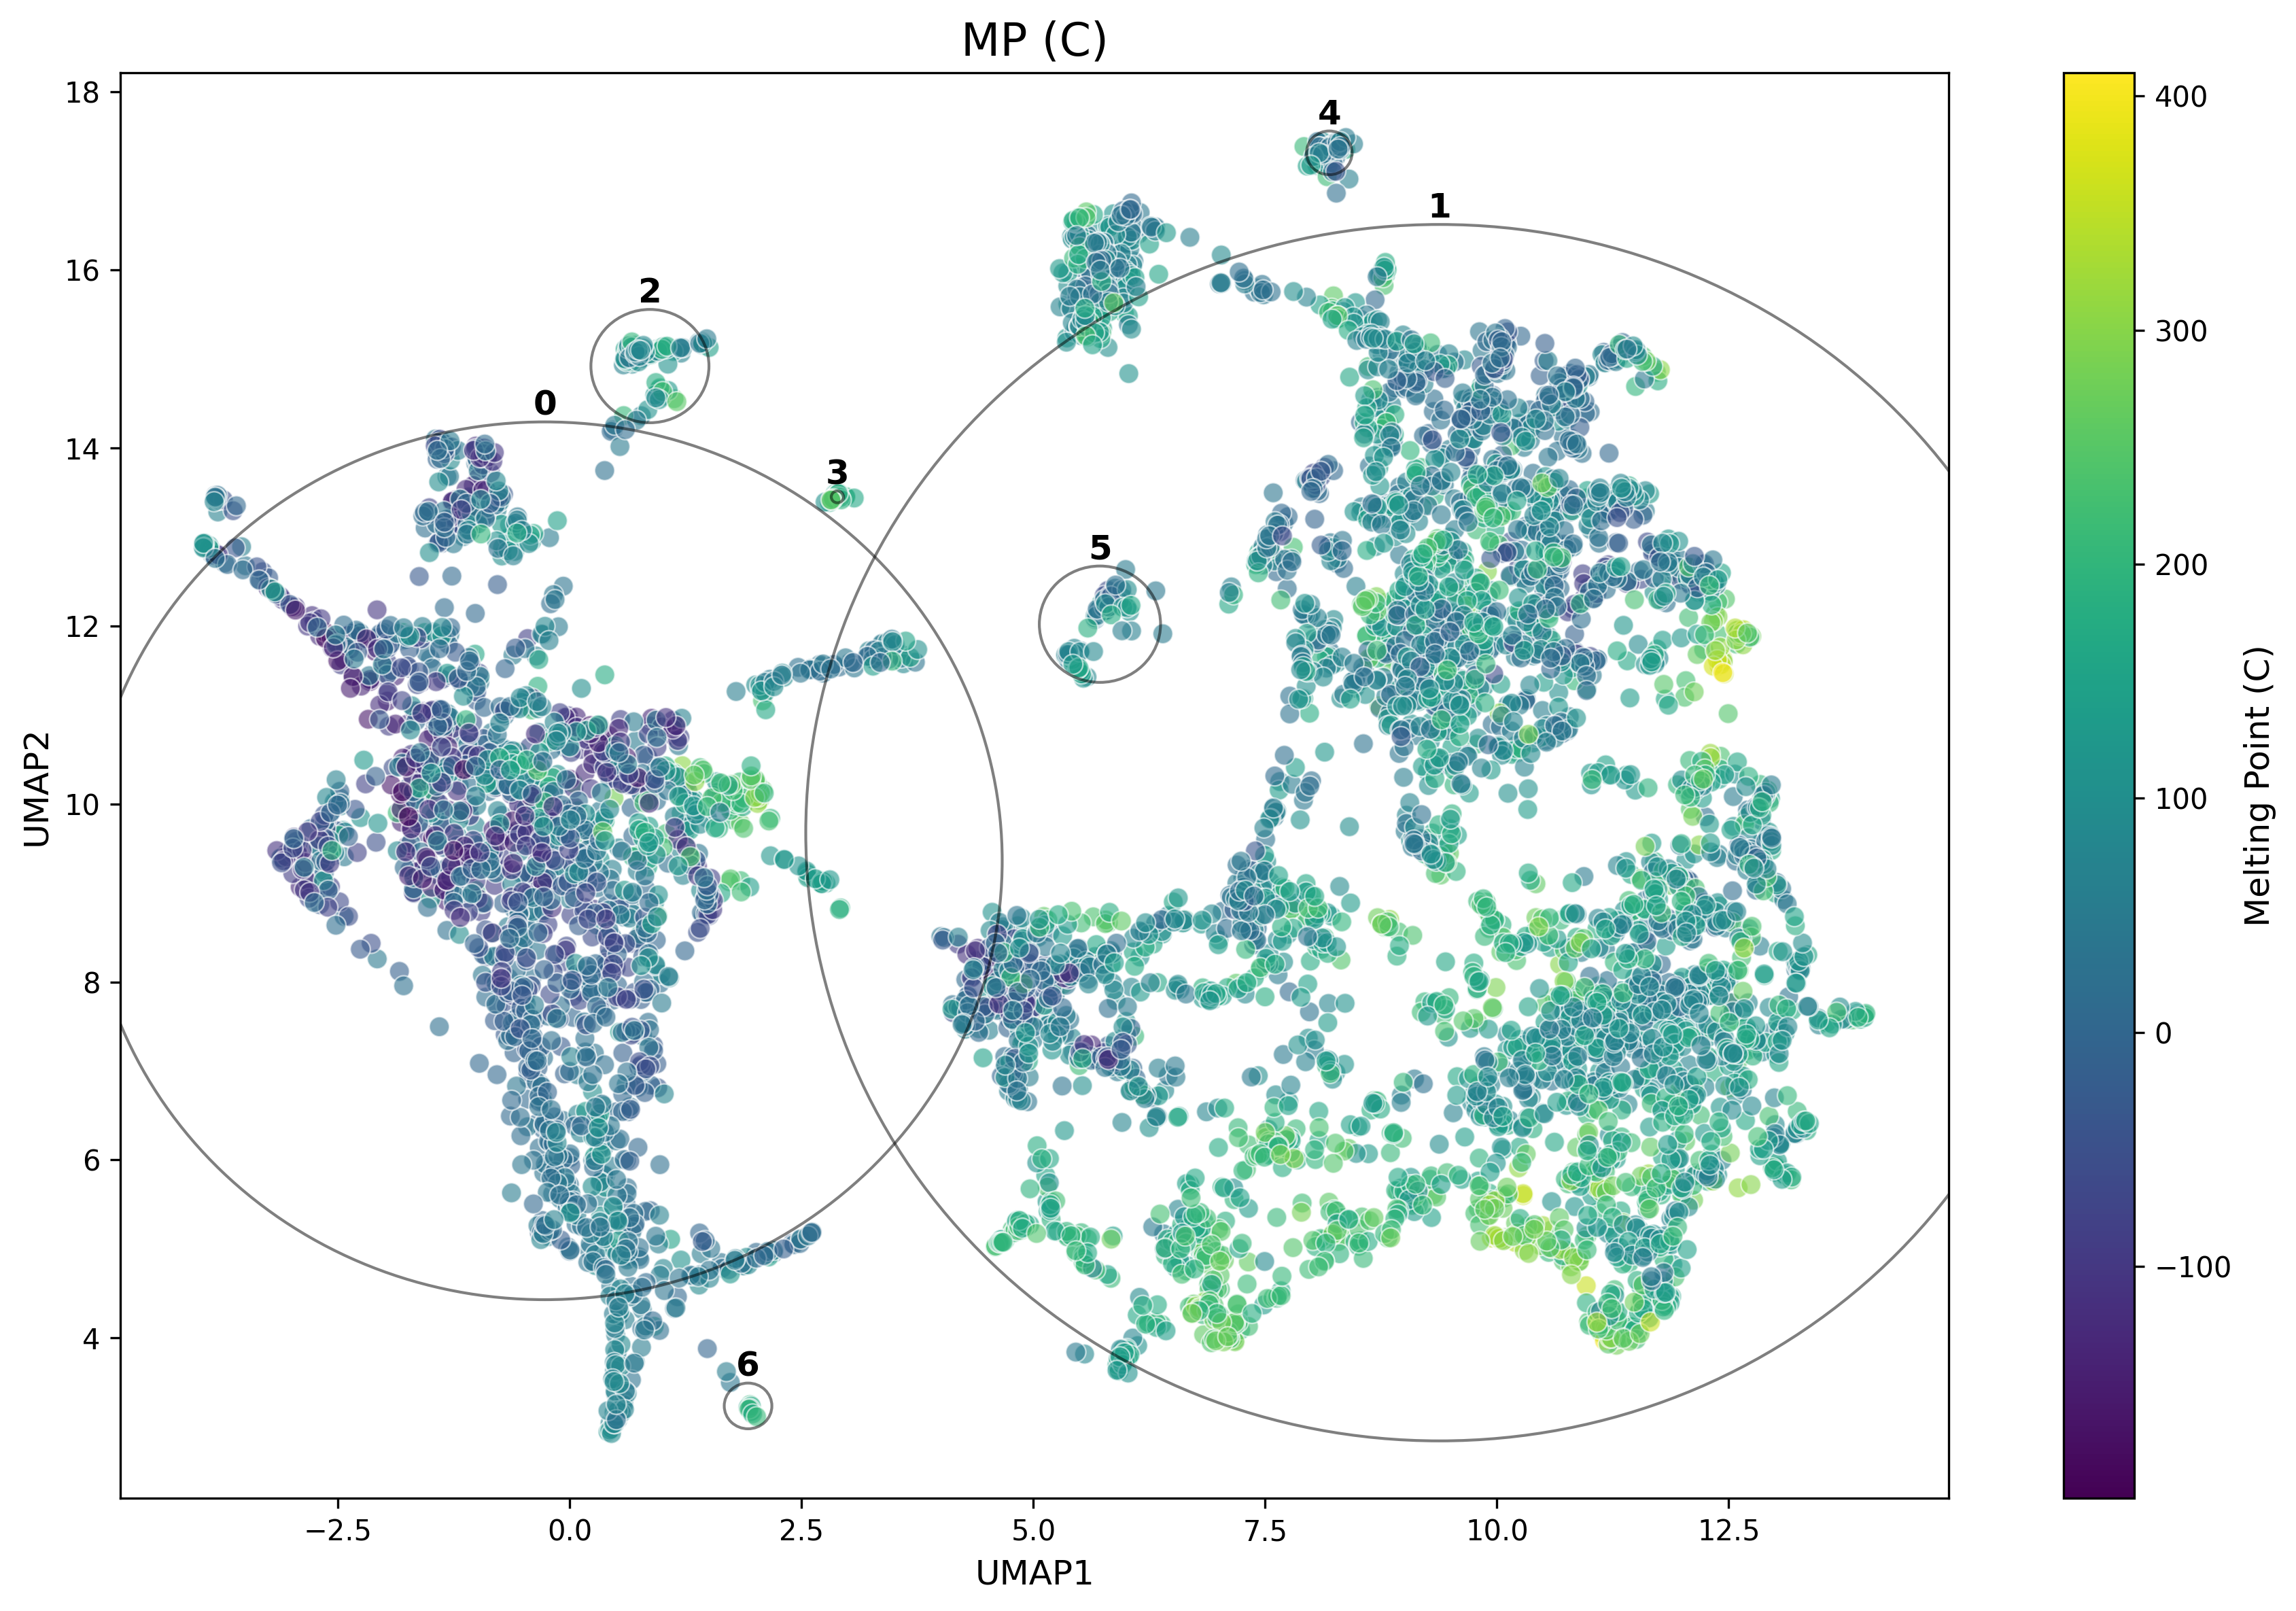

In [7]:
def load_and_preprocess_data(ind=0):
    """Loads and preprocesses data from a Parquet file."""

    df = pd.read_parquet(embedded_vectors_dir[ind] / 'processed_mol2vec_embeddings' / 'processed_df.parquet')
    label_issues_df = pd.read_parquet(
        embedded_vectors_dir[ind] / 'processed_mol2vec_embeddings' / 'label_issues_xgboost.parquet'
    )
    cleaned_df = df[~label_issues_df["is_label_issue"]]
    X = cleaned_df.values[:, 2:]
    y = cleaned_df['y'].values
    smiles_list = cleaned_df['SMILES'].to_list()
    return X, y, smiles_list, cleaned_df

def perform_dimensionality_reduction(X_scaled, method='umap', **kwargs):
    """Performs dimensionality reduction using UMAP or t-SNE."""
    
    if method == 'umap':
        reducer = umap.UMAP(**kwargs)
    elif method == 'tsne':
        reducer = TSNE(**kwargs)
    else:
        raise ValueError("Unknown dimensionality reduction method")
    
    return reducer.fit_transform(X_scaled)


ind = 0
print(f'Property: {property_names[ind]} ({property_units[ind]})')
X, y, smiles_list, cleaned_df = load_and_preprocess_data(ind)
print(f'X: {X.shape}, y: {y.shape}, SMILES: {len(smiles_list)}')

# Scale embeddings
print("Scaling embeddings...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction parameters
print("Performing UMAP...")
n_neighbors = 25
min_dist = 0.3
random_state = 42
# perplexity = 3

reduced_embeddings = perform_dimensionality_reduction(
    X_scaled, 'umap', n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state
)

print(f'UMAP done: {reduced_embeddings.shape}')

# DBSCAN clustering parameters

dbscan_eps = 0.7
dbscan_min_samples = 15

print("Analyzing clusters...")
analyzer = ChemicalClusterAnalyzer()
labels, cluster_analysis = analyzer.analyze_cluster_chemistry(
    reduced_embeddings,
    smiles_list,
    eps=dbscan_eps,
    min_samples=dbscan_min_samples,
)

umap_df = pd.DataFrame(
    {
        "INDEX": cleaned_df.index,
        "UMAP1": reduced_embeddings[:, 0],
        "UMAP2": reduced_embeddings[:, 1],
        "Cluster": labels,
        "SMILES": smiles_list,
        "y": y,
    }
)

# print("Calculating trustworthiness for reduced embeddings...")
# trust = trustworthiness(X, reduced_embeddings, n_neighbors=5)
# print(f"Trustworthiness: {trust:.2f}")

# cluster_labels = umap_df['Cluster'].to_numpy()
# dbcv_score = dbcv(reduced_embeddings, cluster_labels)
# print(f'DBCV score: {dbcv_score}')

# umap_df = pd.read_parquet(
#     embedded_vectors_dir[ind] / f'processed_mol2vec_embeddings/umap/cleaned_label_issues_xgboost/[umap_df]_{names[ind]}_scaled_random_state_42_umap_25_0.3_2_cluster_eps_0.7_min_samples_15.parquet'
# )

title_name = f'{property_names[ind]} ({property_units[ind]})'
short_title_name = f'{titles[ind]} ({property_units[ind]})'
fig, ax = static_fig(umap_df, title_name, short_title_name)
ax = annotate_fig(umap_df, ax)
# fig.savefig(plots_dir / f'{names[ind]}_umap.png')
# fig.savefig(plots_dir / f'{names[ind]}_umap.pdf')
plt.show()

### Load and preprocess data

In [8]:
ind = 0
print(f'Property: {property_names[ind]} ({property_units[ind]})')
X, y, smiles_list, cleaned_df = load_and_preprocess_data(ind)
print(f'X: {X.shape}, y: {y.shape}, SMILES: {len(smiles_list)}')

Property: Melting Point (C)
X: (6167, 300), y: (6167,), SMILES: 6167


### Scale and perform dimensionality reduction

In [10]:
# Scale embeddings
print("Scaling embeddings...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction parameters
print("Performing UMAP...")
n_neighbors = 25
min_dist = 0.3
random_state = 42
# perplexity = 3

reduced_embeddings = perform_dimensionality_reduction(
    X_scaled, 'umap', n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state
)

print(f'UMAP done: {reduced_embeddings.shape}')

Scaling embeddings...
Performing UMAP...
UMAP done: (6167, 2)


### Cluster data

In [8]:
import random

def cluster_figures(umap_df: pd.DataFrame, num_molecules: int = 5):
    
    cluster_ids = sorted(umap_df["Cluster"].unique())
    
    # remove noise points
    cluster_ids = [i for i in cluster_ids if i != -1]
    n_clusters = len(cluster_ids)

    # Create figure
    fig, axes = plt.subplots(num_molecules, n_clusters, figsize=(12, 5), dpi=300)

    for cluster_id in cluster_ids:
        if cluster_id == -1:
            continue
        
        smiles_list = umap_df[umap_df["Cluster"] == cluster_id]["SMILES"].tolist()
        # mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list[:num_molecules]]
        mols = [Chem.MolFromSmiles(smiles) for smiles in random.sample(smiles_list, num_molecules)]
        
        for img_idx, mol in enumerate(mols):
            # Load image
            try:
                # Adjust this path according to your image storage structure
                
                img = Chem.Draw.MolToImage(mol, size=(500, 200))
                # Convert PIL image to numpy array for matplotlib
                img_array = np.array(img)
                
                # Display image
                axes[img_idx, cluster_id].imshow(img_array)
                axes[img_idx, cluster_id].axis('off')  # Turn off axes
                
                # Add column labels (cluster numbers) at the top
                if img_idx == 0:
                    axes[img_idx, cluster_id].set_title(f'Cluster {cluster_id}')
                    
            except Exception as e:
                print(f"Error loading image for cluster {cluster_id}, image {img_idx}: {e}")

    

    # Save the figure
    # plt.savefig('cluster_grid.pdf', bbox_inches='tight', dpi=300)
    # plt.savefig('cluster_grid.png', bbox_inches='tight', dpi=300)
    # plt.close()
    
    plt.show()
    
    return fig, axes

#### DBSCAN clustering parameters optimization

In [78]:
from sklearn.model_selection import ParameterGrid

def optimize_dbscan(X, eps_range, min_samples_range):
    """
    Optimizes DBSCAN parameters eps and min_samples using DBCV.

    Args:
    X: The data array.
    eps_range: A list or range of values for eps.
    min_samples_range: A list or range of values for min_samples.

    Returns:
    A dictionary containing the best eps, best min_samples, and the corresponding 
    DBCV score.
    """

    best_score = float('inf')  # Initialize with a high value since lower DBCV is better
    best_params = {}

    param_grid = ParameterGrid({'eps': eps_range, 'min_samples': min_samples_range})
    for params in tqdm(param_grid):
        dbscan = DBSCAN(**params)
        labels = dbscan.fit_predict(X)

        # Handle cases with only one cluster or all noise
        if len(set(labels)) <= 1:
            continue

        # Calculate DBCV (using Euclidean distance as an example)
        dbcv_score = dbcv(X, labels)
        if dbcv_score < best_score:
            best_score = dbcv_score
            best_params = params

    return {
        'best_eps': best_params['eps'], 
        'best_min_samples': best_params['min_samples'], 
        'best_score': best_score
    }
    
    
# Define the parameter ranges
eps_range = np.arange(0.1, 1.0, 0.1)
min_samples_range = range(5, 50, 2)

# Optimize DBSCAN parameters
# best_params = optimize_dbscan(reduced_embeddings, eps_range, min_samples_range)
# print(f"Best parameters: {best_params}")

100%|██████████| 207/207 [17:31<00:00,  5.08s/it]

Best parameters: {'best_eps': 0.7000000000000001, 'best_min_samples': 41, 'best_score': -0.8153349081820552}


#### Optimising using Optuna

In [79]:
import optuna

def objective(trial: optuna.Trial):
    eps = trial.suggest_uniform('eps', 0.1, 1.0)
    min_samples = trial.suggest_int('min_samples', 5, 50)
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(reduced_embeddings)
    
    # Calculate DBCV
    dbcv_score = dbcv(reduced_embeddings, labels)
    
    return dbcv_score

optuna_storage_file = pt.cwd() / 'dbscan_optuna.db'
storage = f"sqlite:///{str(optuna_storage_file)}"
study_name = f"dbscan_optimization_{names[ind]}"
study = optuna.create_study(direction='minimize', study_name=study_name, storage=storage)
study.optimize(objective, n_trials=100)

[I 2025-01-04 15:43:16,912] A new study created in RDB with name: dbscan_optimization_tmpC_topelements
[I 2025-01-04 15:43:26,319] Trial 0 finished with value: 0.1541290239133444 and parameters: {'eps': 0.9985572860887583, 'min_samples': 11}. Best is trial 0 with value: 0.1541290239133444.
[I 2025-01-04 15:43:35,470] Trial 1 finished with value: 0.04018867501211734 and parameters: {'eps': 0.9653547960979983, 'min_samples': 50}. Best is trial 1 with value: 0.04018867501211734.
[I 2025-01-04 15:43:45,079] Trial 2 finished with value: 0.27744348464246665 and parameters: {'eps': 0.9920725156299811, 'min_samples': 27}. Best is trial 1 with value: 0.04018867501211734.
[I 2025-01-04 15:43:48,224] Trial 3 finished with value: -0.4195181887951639 and parameters: {'eps': 0.493371907681606, 'min_samples': 29}. Best is trial 3 with value: -0.4195181887951639.
[I 2025-01-04 15:43:49,600] Trial 4 finished with value: 0.016698465637435364 and parameters: {'eps': 0.24149178189720538, 'min_samples': 43

In [81]:
study.best_params, study.best_value

({'eps': 0.7472369027324188, 'min_samples': 47}, -0.8500208347830659)

Analyzing clusters...


100%|██████████| 11/11 [00:01<00:00,  9.51it/s]


<Figure size 640x480 with 0 Axes>

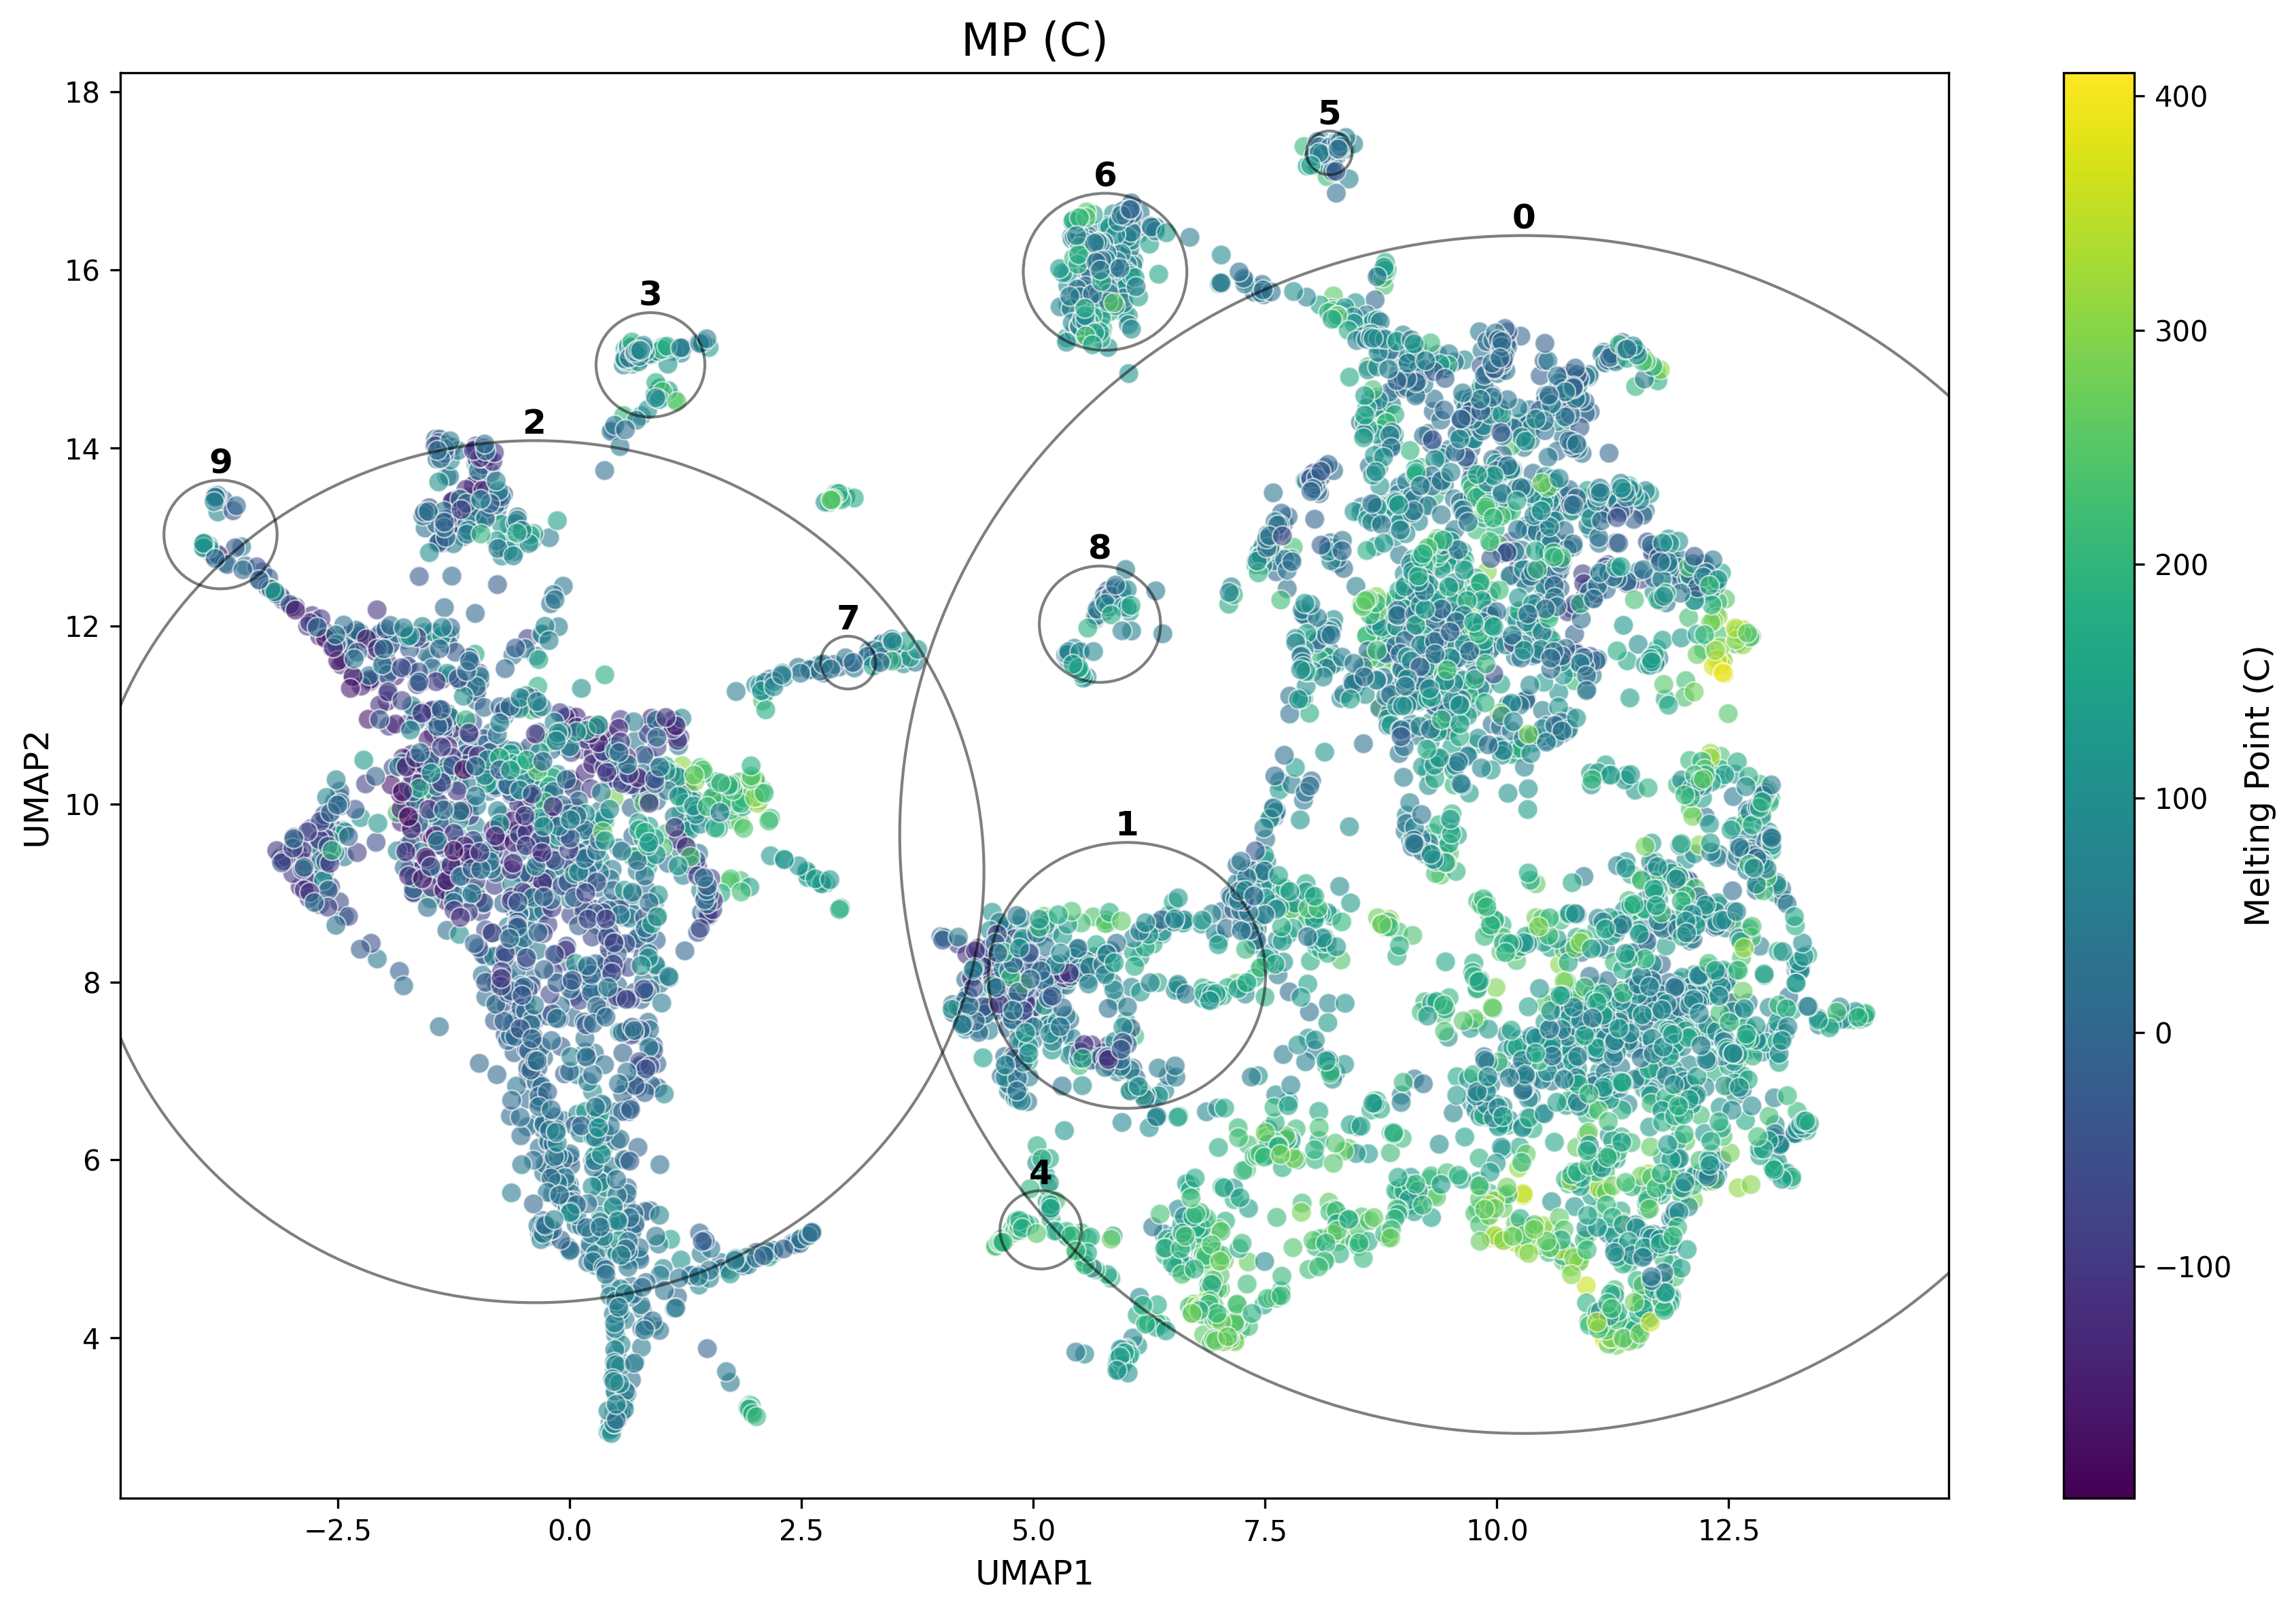

In [93]:
dbscan_eps = 0.7 
# eps defines the maximum distance between two points for them to be considered neighbors
# Impact on Clustering:
# Small eps: Leads to smaller, more fragmented clusters. Many points might be classified as noise.
# Large eps: Leads to larger, more connected clusters. Clusters might merge together, and fewer points will be considered noise

dbscan_min_samples = 47
# min_samples specifies the minimum number of data points required within an eps-neighborhood for a point to be considered a core point. Core points are the "seeds" of clusters.
# Impact on Clustering:
# Small min_samples: Allows for clusters with lower density. More points will be included in clusters, potentially including noise.   
# Large min_samples: Requires higher density for cluster formation. Clusters will be more compact, and more points might be classified as noise. 

print("Analyzing clusters...")
analyzer = ChemicalClusterAnalyzer()
labels, cluster_analysis = analyzer.analyze_cluster_chemistry(
    reduced_embeddings,
    smiles_list,
    eps=dbscan_eps,
    min_samples=dbscan_min_samples,
)

umap_df = pd.DataFrame(
    {
        "INDEX": cleaned_df.index,
        "UMAP1": reduced_embeddings[:, 0],
        "UMAP2": reduced_embeddings[:, 1],
        "Cluster": labels,
        "SMILES": smiles_list,
        "y": y,
    }
)

title_name = f'{property_names[ind]} ({property_units[ind]})'
short_title_name = f'{titles[ind]} ({property_units[ind]})'
fig, ax = static_fig(umap_df, title_name, short_title_name)
ax = annotate_fig(umap_df, ax)
# fig.savefig(plots_dir / f'{names[ind]}_umap.png')
# fig.savefig(plots_dir / f'{names[ind]}_umap.pdf')
plt.show()

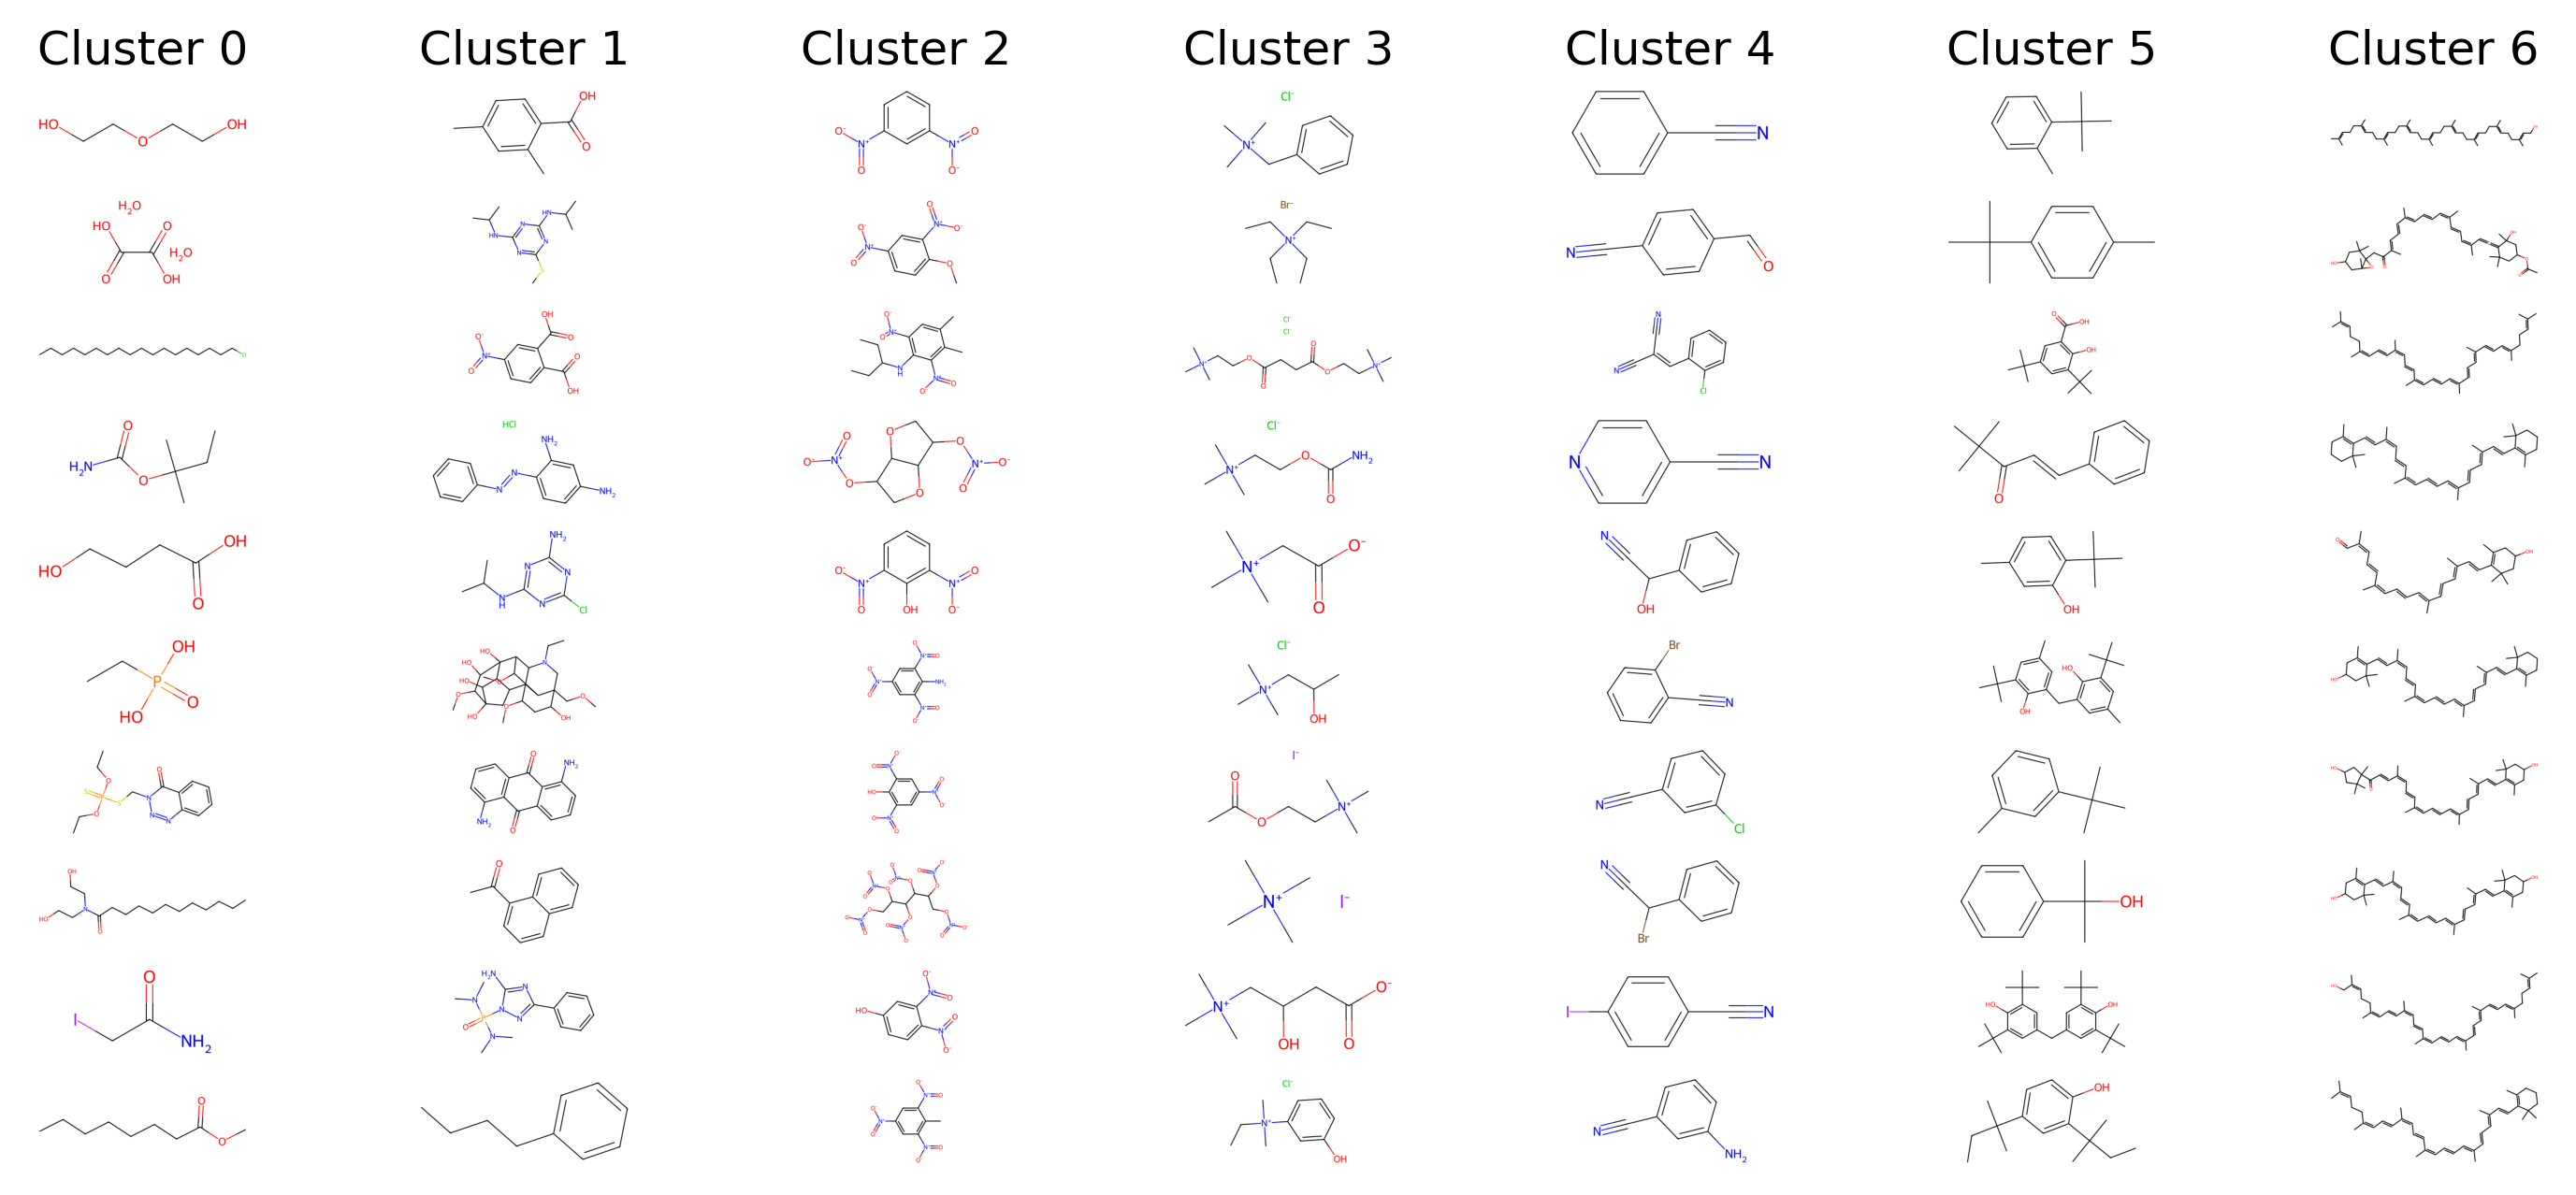

<Figure size 640x480 with 0 Axes>

In [9]:
fig, axes = cluster_figures(umap_df, num_molecules=10)
# Adjust layout
plt.tight_layout()

# fig.savefig('cluster_grid.png', bbox_inches='tight', dpi=300)
# fig.savefig('cluster_grid.pdf', bbox_inches='tight', dpi=300)
plt.show()
# plt.close(fig)

In [84]:
display(umap_df)
cluster_labels = umap_df['Cluster'].to_numpy()
reduced_embeddings = umap_df[['UMAP1', 'UMAP2']].to_numpy()

INDEX      UMAP1      UMAP2  Cluster  \
0         0   3.573678  11.681543        7   
1         1   6.689068   5.721889        0   
2         2   7.107500  12.245457        0   
3         3  10.334067   5.175545        0   
4         4   9.249722  10.367277        0   
...     ...        ...        ...      ...   
6162   7633  10.399973   5.219956        0   
6163   7634   5.458055   4.978056        4   
6164   7635   9.270604  11.294572        0   
6165   7636   8.257914   6.187415        0   
6166   7638   8.932773   5.803943        0   

                                                 SMILES      y  
0         COP(=S)(OC)Oc1ccc(Sc2ccc(OP(=S)(OC)OC)cc2)cc1   31.6  
1             CC(C)C1=CC2=CCC3C(C)(C(=O)O)CCCC3(C)C2CC1  173.5  
2                CC(C=CC1(O)C(C)=CC(=O)CC1(C)C)=CC(=O)O  160.0  
3                 COc1ccc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc1  263.0  
4              CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(C(C)=O)c1  121.0  
...                                                 ...    ...  
6162  Cc1cc(C2(c3cc(C)c(O)c(CN(CC(=O)O)CC(=O)O)c3)OS...  286.0  
6163  OC1O[C@H](CO[C@@H]2OC[C@@H](O)[C@H](O)[C@H]2O)...  210.0  
6164                             CNC(=O)Oc1cc(C)cc(C)c1   99.0  
6165     COC(=O)C1C(O)CCC2CN3CCc4c([nH]c5ccccc45)C3CC21  241.0  
6166             CC1CCCC(=O)CCCC=Cc2cc(O)cc(O)c2C(=O)O1  164.0  

[6167 rows x 6 columns]

In [85]:
dbcv_score = dbcv(reduced_embeddings, cluster_labels)
print(f'DBCV score: {dbcv_score}')

DBCV score: -0.7701470660305522


In [ ]:
trust = trustworthiness(X, reduced_embeddings, n_neighbors=5)
print(f"Trustworthiness: {trust:.2f}")

Trustworthiness: 0.97


In [69]:
for ind in range(0, len(embedded_vectors_dir)):
    umap_df = pd.read_parquet(
        embedded_vectors_dir[ind] / f'processed_mol2vec_embeddings/umap/cleaned_label_issues_xgboost/[umap_df]_{names[ind]}_scaled_random_state_42_umap_25_0.3_2_cluster_eps_0.7_min_samples_15.parquet'
    )
    # print(umap_df['Cluster'].unique(), umap_df['Cluster'].value_counts())
    # display(umap_df)

    title_name = f'{property_names[ind]} ({property_units[ind]})'
    short_title_name = f'{titles[ind]} ({property_units[ind]})'
    fig, ax = static_fig(umap_df, title_name, short_title_name)
    ax = annotate_fig(umap_df, ax)
    fig.savefig(plots_dir / f'{names[ind]}_umap.png')
    # plt.show()
    plt.close(fig)
    print(f'{names[ind]} done')

tmpC_topelements done
tbp_topelements done
vp_kPa_25C_topelements done
Pc_MPa done
Tc_K done


<Figure size 640x480 with 0 Axes>

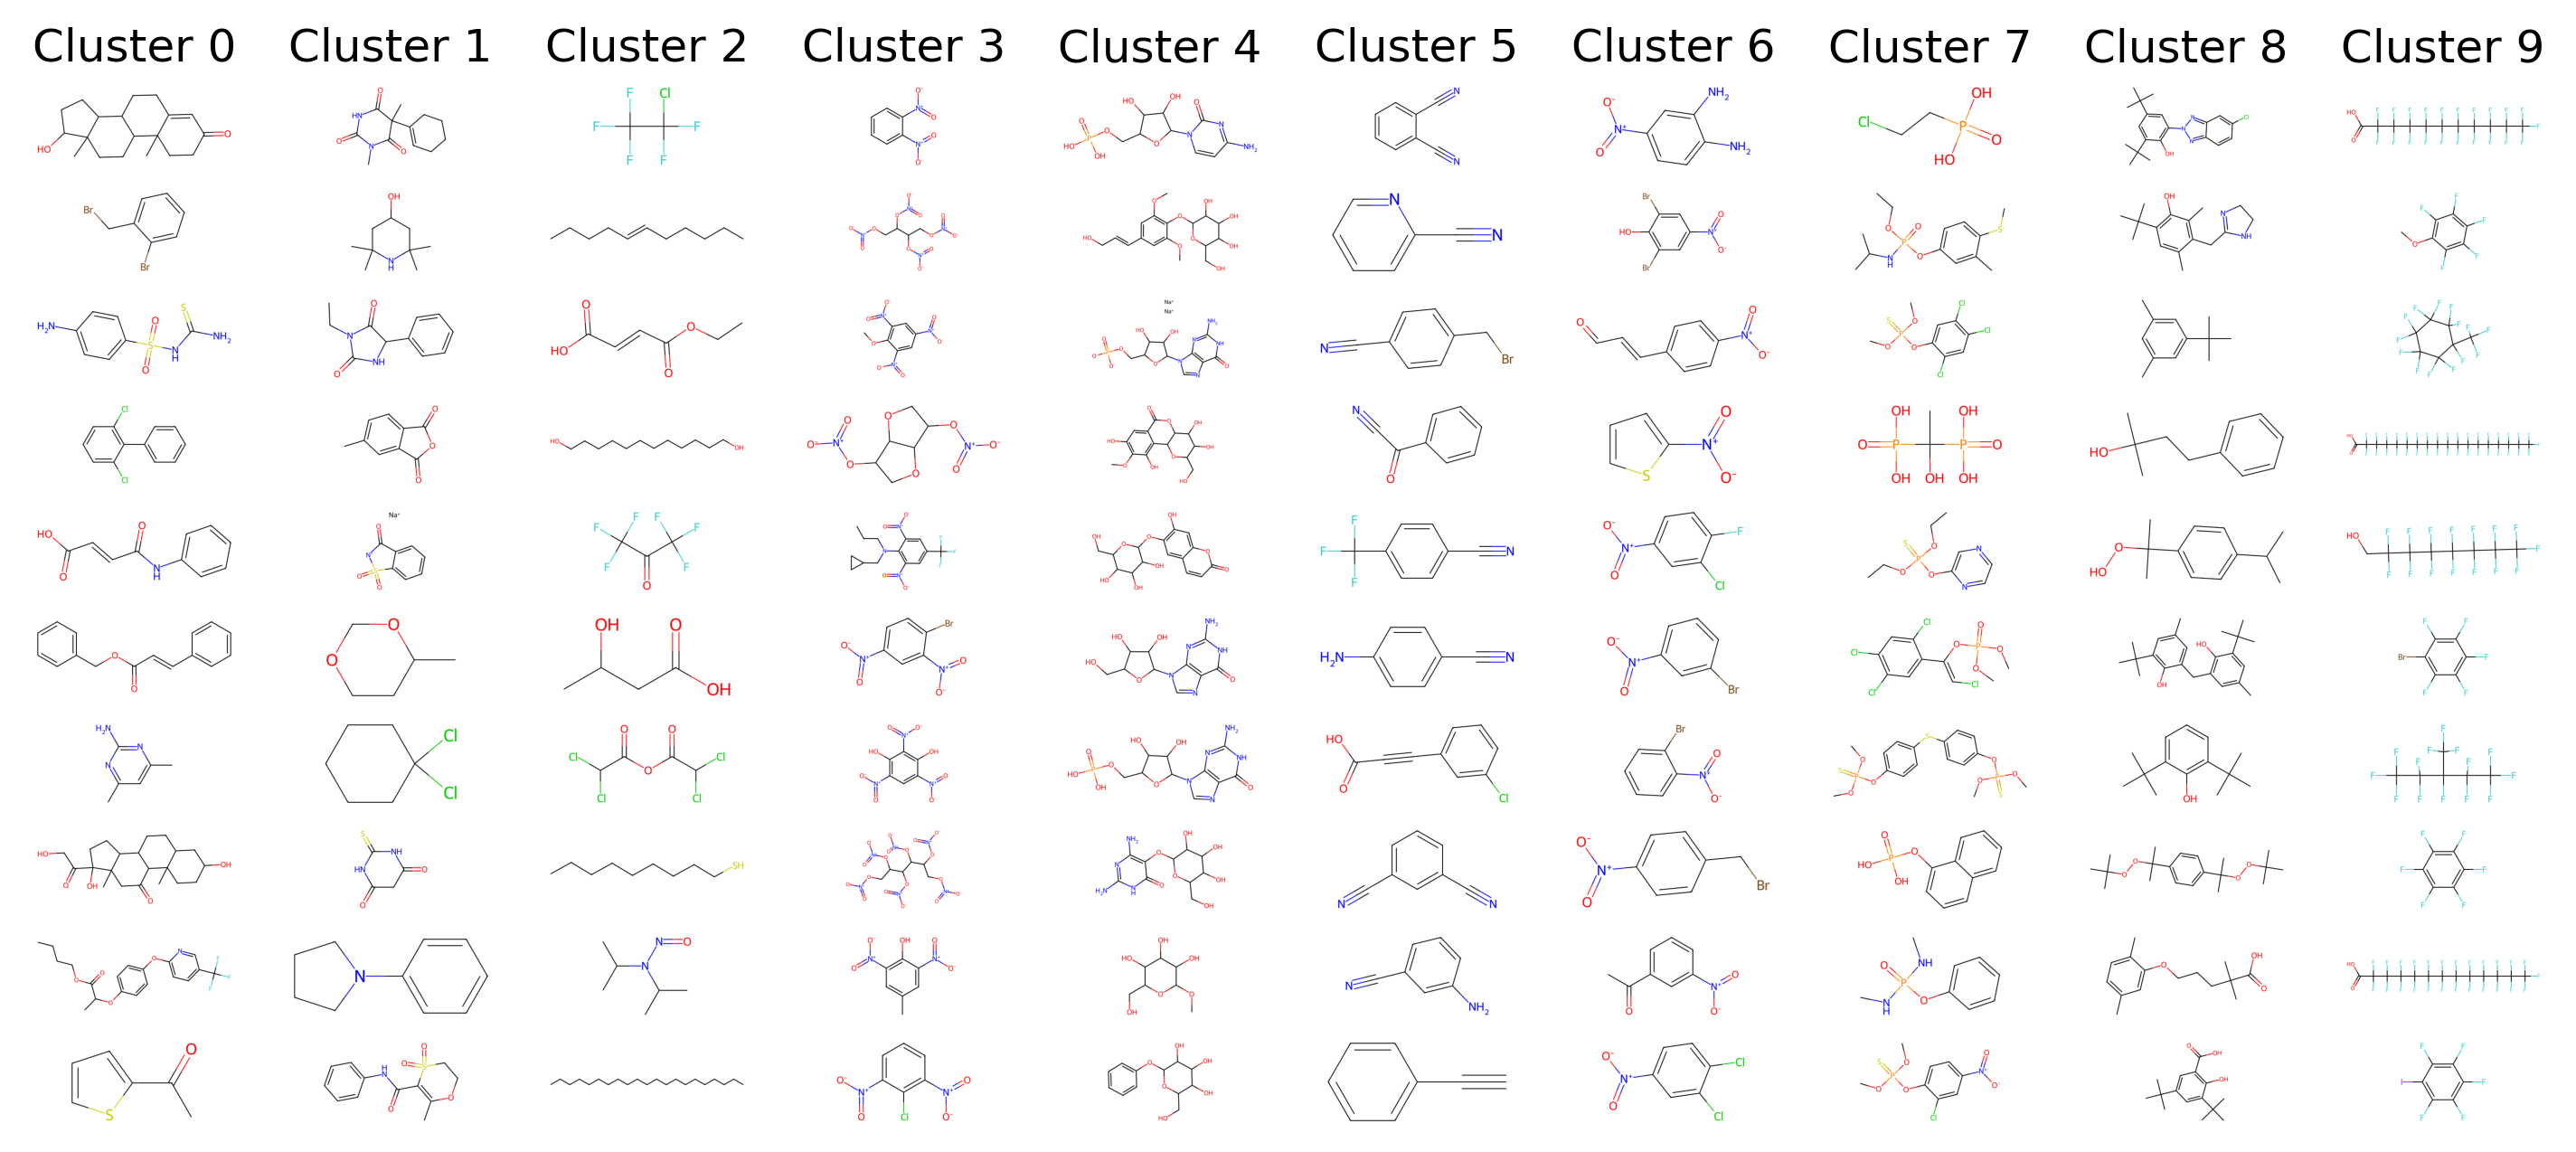

<Figure size 640x480 with 0 Axes>

In [88]:
import random

def cluster_figures(umap_df: pd.DataFrame, num_molecules: int = 5):
    
    cluster_ids = sorted(umap_df["Cluster"].unique())
    
    # remove noise points
    cluster_ids = [i for i in cluster_ids if i != -1]
    n_clusters = len(cluster_ids)

    # Create figure
    fig, axes = plt.subplots(num_molecules, n_clusters, figsize=(12, 5), dpi=300)

    for cluster_id in cluster_ids:
        if cluster_id == -1:
            continue
        
        smiles_list = umap_df[umap_df["Cluster"] == cluster_id]["SMILES"].tolist()
        # mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list[:num_molecules]]
        mols = [Chem.MolFromSmiles(smiles) for smiles in random.sample(smiles_list, num_molecules)]
        
        for img_idx, mol in enumerate(mols):
            # Load image
            try:
                # Adjust this path according to your image storage structure
                
                img = Chem.Draw.MolToImage(mol, size=(500, 200))
                # Convert PIL image to numpy array for matplotlib
                img_array = np.array(img)
                
                # Display image
                axes[img_idx, cluster_id].imshow(img_array)
                axes[img_idx, cluster_id].axis('off')  # Turn off axes
                
                # Add column labels (cluster numbers) at the top
                if img_idx == 0:
                    axes[img_idx, cluster_id].set_title(f'Cluster {cluster_id}')
                    
            except Exception as e:
                print(f"Error loading image for cluster {cluster_id}, image {img_idx}: {e}")

    

    # Save the figure
    # plt.savefig('cluster_grid.pdf', bbox_inches='tight', dpi=300)
    # plt.savefig('cluster_grid.png', bbox_inches='tight', dpi=300)
    # plt.close()
    
    plt.show()
    
    return fig, axes

fig, axes = cluster_figures(umap_df, num_molecules=10)
# Adjust layout
plt.tight_layout()

# fig.savefig('cluster_grid.png', bbox_inches='tight', dpi=300)
# fig.savefig('cluster_grid.pdf', bbox_inches='tight', dpi=300)
plt.show()
# plt.close(fig)